**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


In [2]:
gputools_available()

False

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [3]:
# X_fnames = sorted(glob('data/train/images/*.tif'))
# Y_fnames = sorted(glob('data/train/masks/*.tif'))
# NEW: use segmentation party training data
X_fnames = sorted(glob('data/train_segmentation_party/images/*.tiff'))
Y_fnames = sorted(glob('data/train_segmentation_party/masks/*.tiff'))
assert all(Path(x).name==Path(y).name for x,y in zip(X_fnames,Y_fnames))

In [13]:
# from wbfm.utils.video_and_data_conversion.import_video_as_array import get_single_volume
# f = lambda fname, i : get_single_volume(fname, i, 33, dtype='uint16')
# num_frames = 100

# NEW: use segmentation party training data
X_raw_one_file = tifffile.imread(X_fnames[0])
Y_raw_one_file = tifffile.imread(Y_fnames[0])
num_frames = X_raw_one_file.shape[0]

In [14]:
# X_raw = list(map(imread,X))
# X_raw = [f(X_fnames[0], i) for i in range(num_frames)]
X_raw = [X_raw_one_file[i,...] for i in range(num_frames)]
# Y_raw = list(map(imread,Y))
# Y_raw = [f(Y_fnames[0], i) for i in range(num_frames)]
Y_raw = [Y_raw_one_file[i,...] for i in range(num_frames)]

n_channel = 1 if X_raw[0].ndim == 3 else X_raw[0].shape[-1]

In [15]:
# NEW: translate from video to list of volumes
# X, Y = np.array(X_raw[0],dtype='uint16'), np.array(Y_raw[0],dtype='uint16')
ind_vec = list(range(X_raw[0].shape[0]))

In [16]:
Y_raw[0].shape, len(Y_raw)

((29, 700, 900), 14)

Normalize images and fill small label holes.

In [17]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

# NEW: translate from video to list of volumes
# X = [normalize(np.array(X[i,...],dtype='uint8'),1,99.8,axis=axis_norm) for i in tqdm(ind_vec)]
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_raw)]
# BROKEN LINE
# Y = [fill_label_holes(np.array(Y[i,...],dtype='uint8')) for i in tqdm(ind_vec)]
Y = [fill_label_holes(np.array(y,dtype='uint8')) for y in tqdm(Y_raw)]


100%|██████████| 14/14 [00:02<00:00,  6.59it/s]


Split into train and validation datasets.

In [18]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  14
- training:        12
- validation:       2


Training data consists of pairs of input image and label instances.

In [19]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

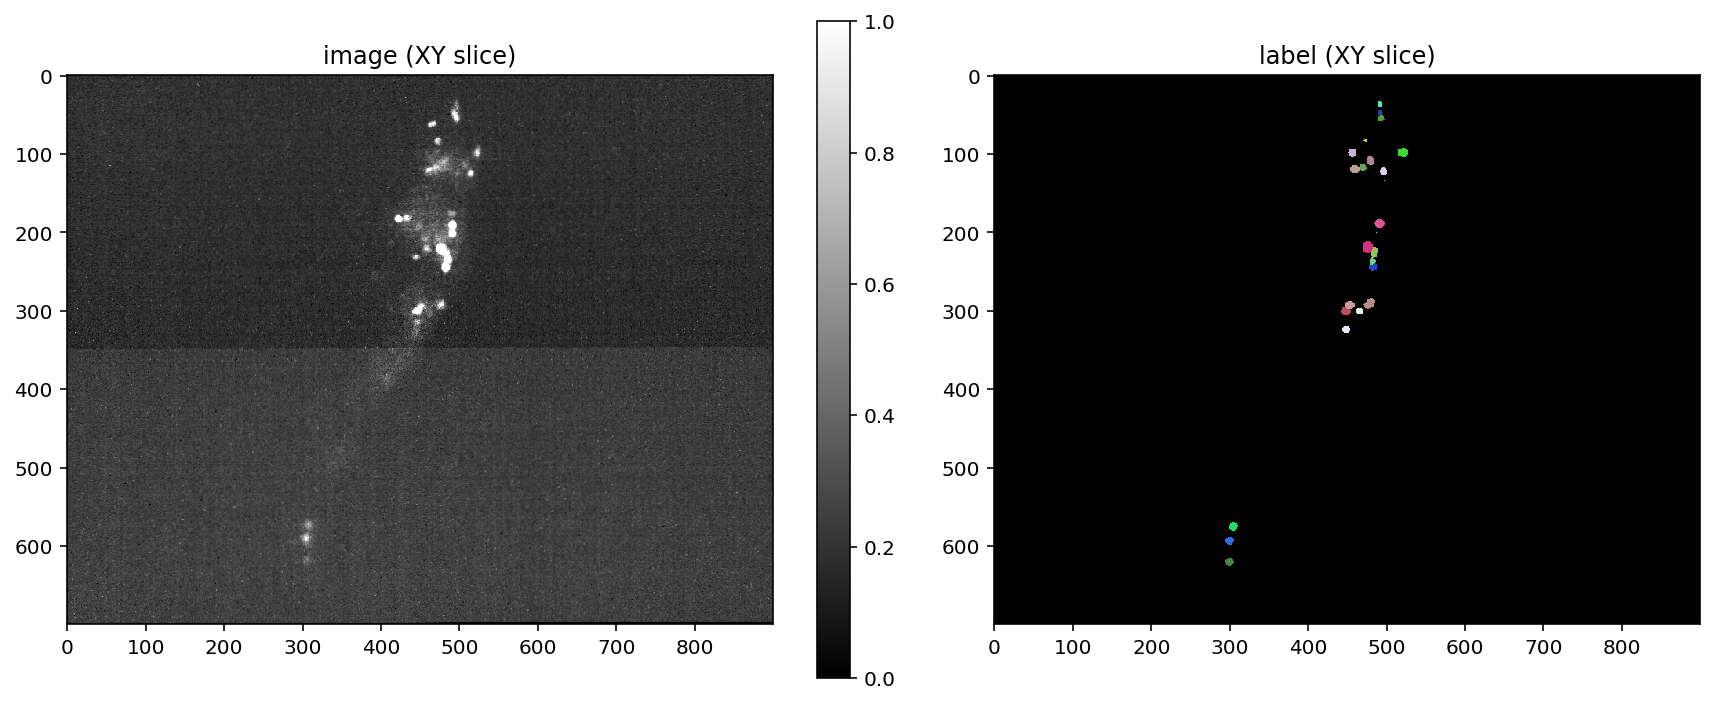

In [20]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [21]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
  

In [22]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.3333333333333333, 1.0909090909090908, 1.0)


In [34]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (8,96,96),
    train_batch_size = 2,
)
print(conf)
vars(conf)

Config3D(anisotropy=(1.3333333333333333, 1.0909090909090908, 1.0), axes='ZYXC', backbone='unet', grid=(2, 2, 2), n_channel_in=1, n_channel_out=97, n_classes=None, n_dim=3, n_rays=96, net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.3333333333333333, 1.0909090909090908, 1.0)}}, train_background_reg=0.0001, train_batch_size=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(8, 96, 96), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kerne

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (2, 2, 2),
 'anisotropy': (1.3333333333333333, 1.0909090909090908, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96,
   'anisotropy': (1.3333333333333333, 1.0909090909090908, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (8, 96, 96),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae

In [35]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [36]:
model = StarDist3D(conf, name='Charlie100-3d-party', basedir='models')

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.353429, nms_thresh=0.3.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [37]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [ 9. 11. 12.]
network field of view :  [46 46 46]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [38]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y


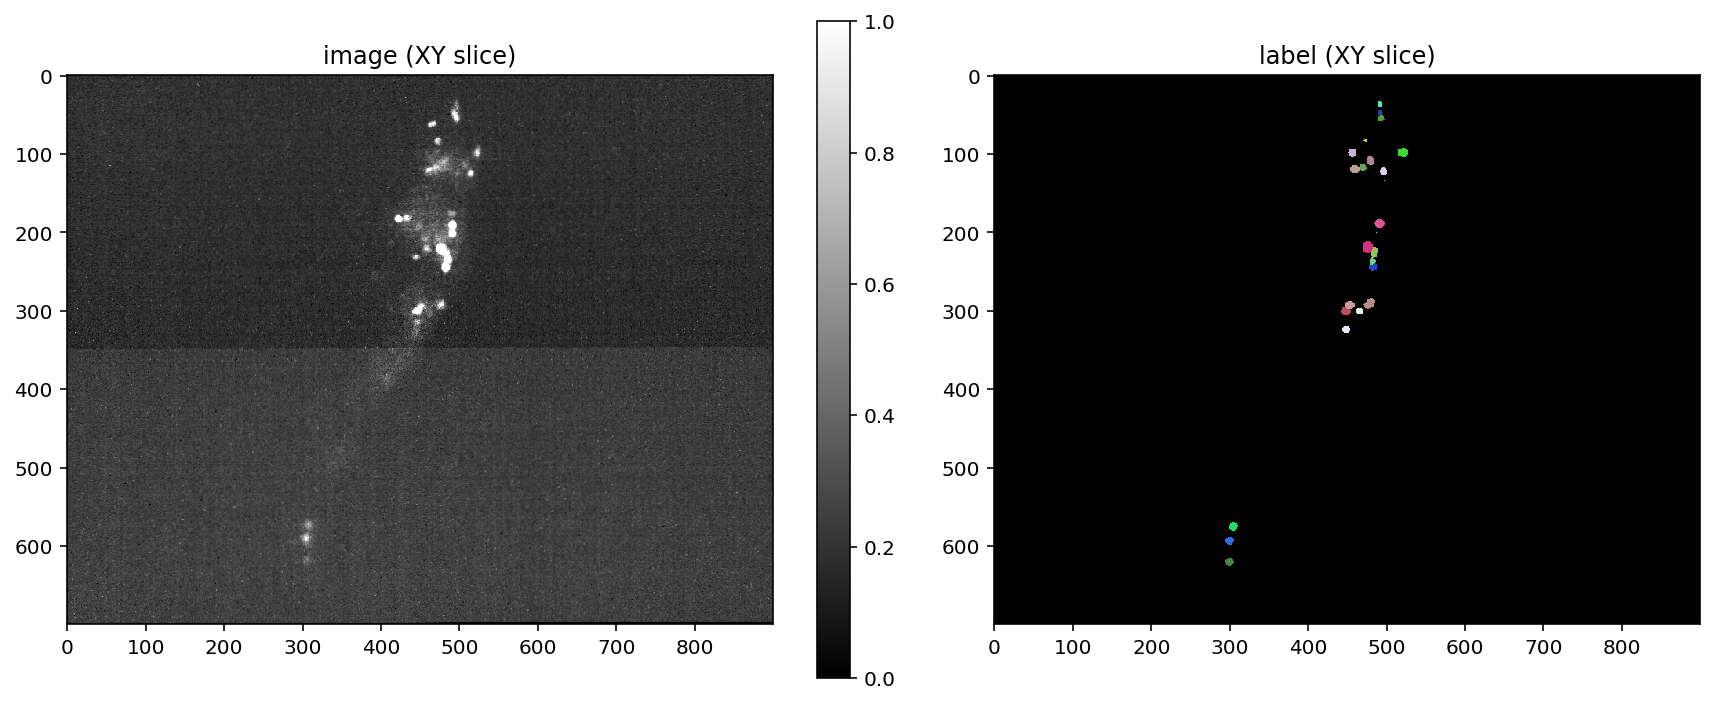

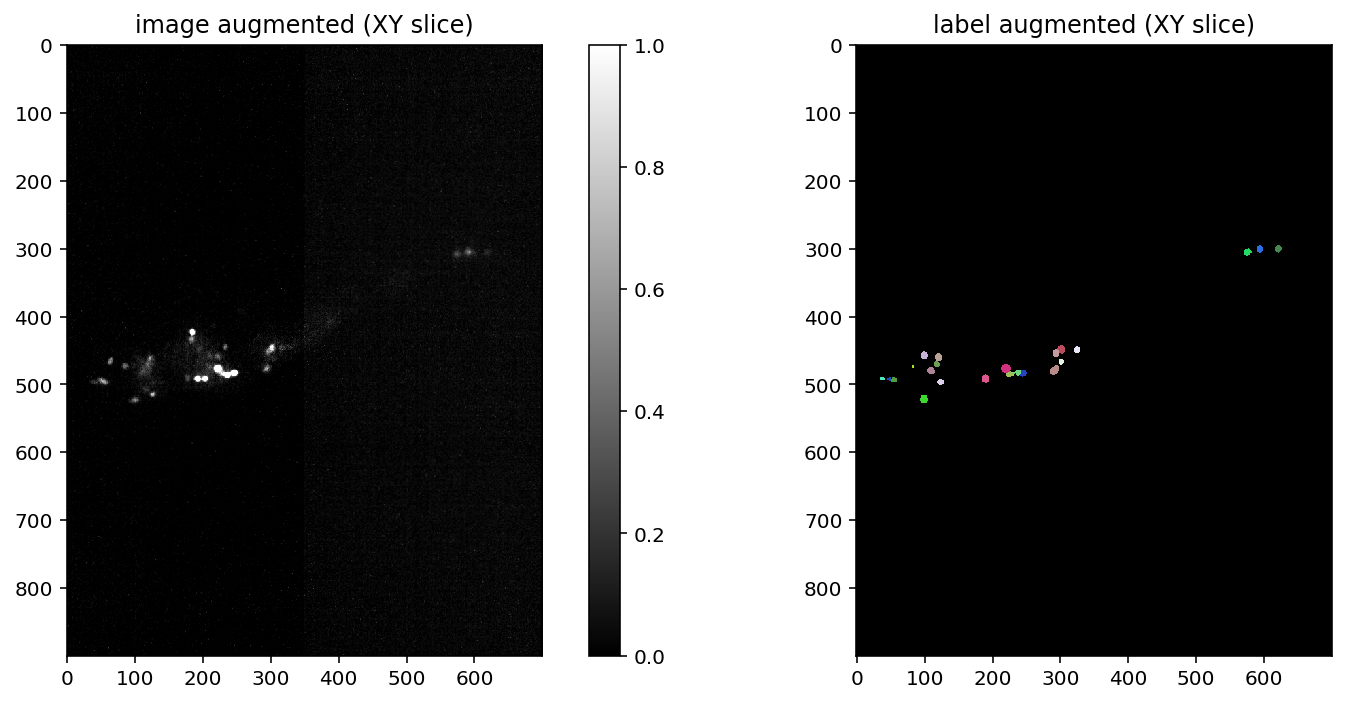

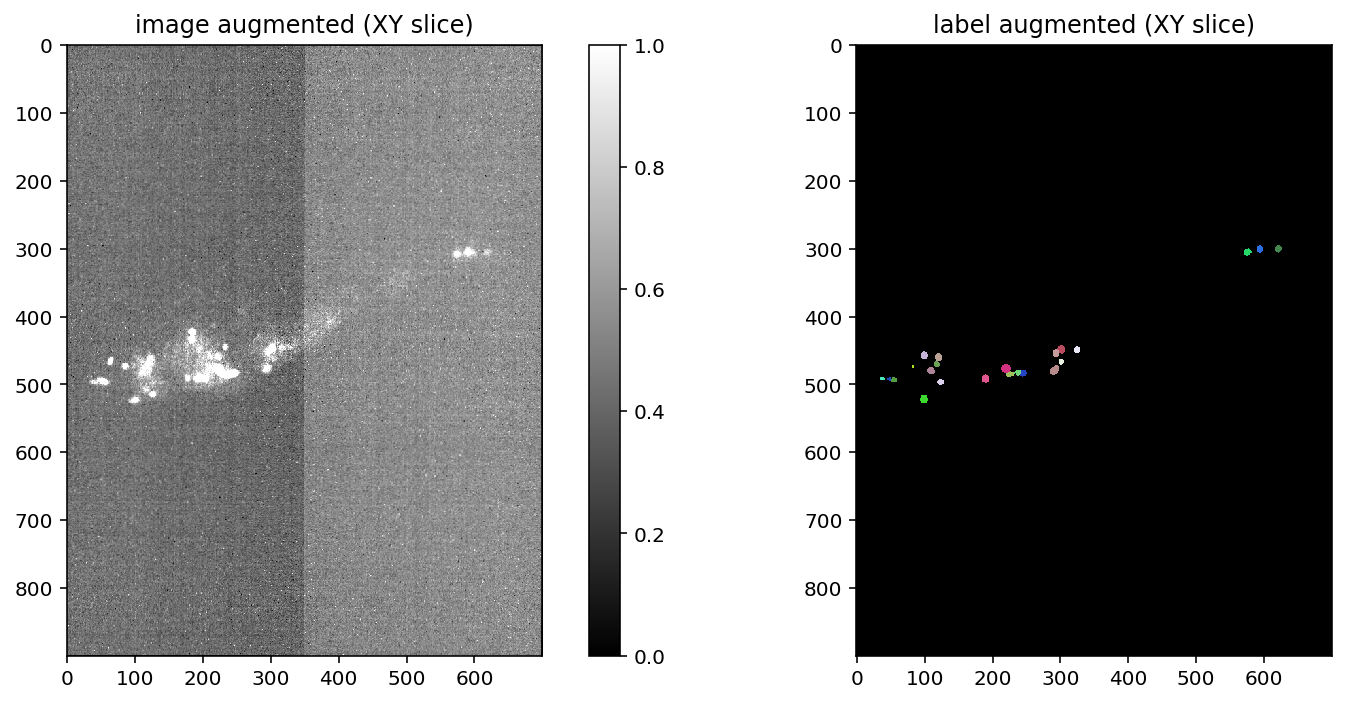

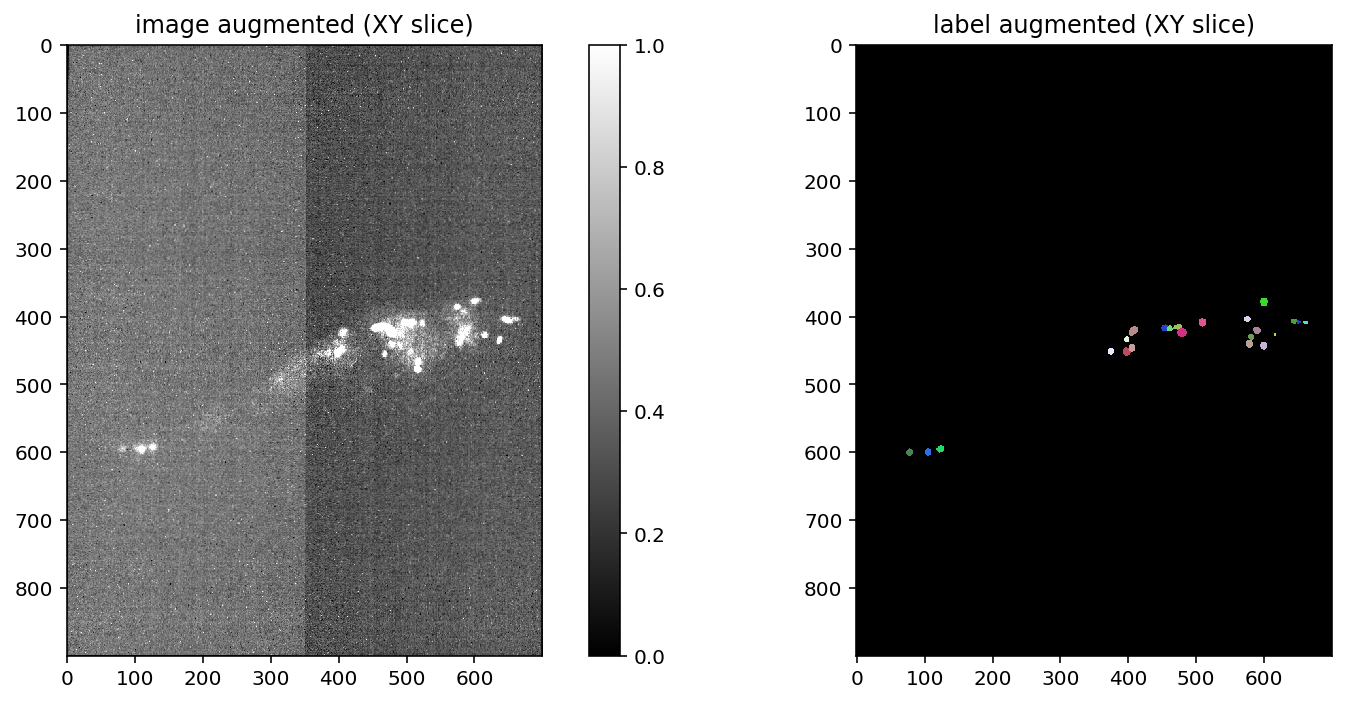

In [39]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [40]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/400
100/100 [==============================] - 18s 178ms/step - loss: 0.8516 - prob_loss: 0.2274 - dist_loss: 3.1209 - prob_kld: 0.1874 - dist_relevant_mae: 3.1208 - dist_relevant_mse: 15.4764 - dist_dist_iou_metric: 0.1081 - val_loss: 0.4041 - val_prob_loss: 0.0365 - val_dist_loss: 1.8380 - val_prob_kld: 0.0302 - val_dist_relevant_mae: 1.8377 - val_dist_relevant_mse: 6.1664 - val_dist_dist_iou_metric: 0.3509

Epoch 2/400
100/100 [==============================] - 9s 86ms/step - loss: 0.4609 - prob_loss: 0.0949 - dist_loss: 1

100/100 [==============================] - 8s 83ms/step - loss: 0.3711 - prob_loss: 0.0711 - dist_loss: 1.4998 - prob_kld: 0.0515 - dist_relevant_mae: 1.4994 - dist_relevant_mse: 4.3103 - dist_dist_iou_metric: 0.4576 - val_loss: 0.3767 - val_prob_loss: 0.0335 - val_dist_loss: 1.7156 - val_prob_kld: 0.0272 - val_dist_relevant_mae: 1.7152 - val_dist_relevant_mse: 5.1483 - val_dist_dist_iou_metric: 0.3840
Epoch 17/400
100/100 [==============================] - 8s 80ms/step - loss: 0.3777 - prob_loss: 0.0737 - dist_loss: 1.5201 - prob_kld: 0.0534 - dist_relevant_mae: 1.5197 - dist_relevant_mse: 4.3788 - dist_dist_iou_metric: 0.4617 - val_loss: 0.3595 - val_prob_loss: 0.0303 - val_dist_loss: 1.6459 - val_prob_kld: 0.0240 - val_dist_relevant_mae: 1.6454 - val_dist_relevant_mse: 4.7214 - val_dist_dist_iou_metric: 0.4301
Epoch 18/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3725 - prob_loss: 0.0727 - dist_loss: 1.4989 - prob_kld: 0.0524 - dist_relevant_mae: 1.4985 - di

Epoch 35/400
100/100 [==============================] - 8s 85ms/step - loss: 0.3752 - prob_loss: 0.0758 - dist_loss: 1.4974 - prob_kld: 0.0532 - dist_relevant_mae: 1.4970 - dist_relevant_mse: 4.2865 - dist_dist_iou_metric: 0.4687 - val_loss: 0.3443 - val_prob_loss: 0.0323 - val_dist_loss: 1.5600 - val_prob_kld: 0.0259 - val_dist_relevant_mae: 1.5596 - val_dist_relevant_mse: 4.2625 - val_dist_dist_iou_metric: 0.4215
Epoch 36/400
100/100 [==============================] - 8s 81ms/step - loss: 0.3531 - prob_loss: 0.0668 - dist_loss: 1.4312 - prob_kld: 0.0481 - dist_relevant_mae: 1.4308 - dist_relevant_mse: 4.1110 - dist_dist_iou_metric: 0.4535 - val_loss: 0.3266 - val_prob_loss: 0.0258 - val_dist_loss: 1.5039 - val_prob_kld: 0.0195 - val_dist_relevant_mae: 1.5035 - val_dist_relevant_mse: 3.9517 - val_dist_dist_iou_metric: 0.4827
Epoch 37/400
100/100 [==============================] - 8s 80ms/step - loss: 0.3658 - prob_loss: 0.0652 - dist_loss: 1.5030 - prob_kld: 0.0460 - dist_relevant_mae

Epoch 55/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3630 - prob_loss: 0.0661 - dist_loss: 1.4848 - prob_kld: 0.0468 - dist_relevant_mae: 1.4844 - dist_relevant_mse: 4.2364 - dist_dist_iou_metric: 0.4714 - val_loss: 0.3157 - val_prob_loss: 0.0204 - val_dist_loss: 1.4767 - val_prob_kld: 0.0140 - val_dist_relevant_mae: 1.4763 - val_dist_relevant_mse: 3.8009 - val_dist_dist_iou_metric: 0.4861
Epoch 56/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3514 - prob_loss: 0.0628 - dist_loss: 1.4430 - prob_kld: 0.0439 - dist_relevant_mae: 1.4426 - dist_relevant_mse: 4.1245 - dist_dist_iou_metric: 0.4649 - val_loss: 0.3194 - val_prob_loss: 0.0206 - val_dist_loss: 1.4937 - val_prob_kld: 0.0143 - val_dist_relevant_mae: 1.4933 - val_dist_relevant_mse: 3.9228 - val_dist_dist_iou_metric: 0.4869
Epoch 57/400
100/100 [==============================] - 8s 80ms/step - loss: 0.3556 - prob_loss: 0.0643 - dist_loss: 1.4564 - prob_kld: 0.0443 - dist_relevant_mae

100/100 [==============================] - 8s 77ms/step - loss: 0.3592 - prob_loss: 0.0626 - dist_loss: 1.4830 - prob_kld: 0.0440 - dist_relevant_mae: 1.4826 - dist_relevant_mse: 4.2825 - dist_dist_iou_metric: 0.4716 - val_loss: 0.3116 - val_prob_loss: 0.0214 - val_dist_loss: 1.4509 - val_prob_kld: 0.0151 - val_dist_relevant_mae: 1.4505 - val_dist_relevant_mse: 3.7581 - val_dist_dist_iou_metric: 0.4920
Epoch 75/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3498 - prob_loss: 0.0642 - dist_loss: 1.4279 - prob_kld: 0.0450 - dist_relevant_mae: 1.4275 - dist_relevant_mse: 4.0518 - dist_dist_iou_metric: 0.4565 - val_loss: 0.3057 - val_prob_loss: 0.0190 - val_dist_loss: 1.4333 - val_prob_kld: 0.0127 - val_dist_relevant_mae: 1.4329 - val_dist_relevant_mse: 3.7042 - val_dist_dist_iou_metric: 0.5038
Epoch 76/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3630 - prob_loss: 0.0678 - dist_loss: 1.4761 - prob_kld: 0.0478 - dist_relevant_mae: 1.4757 - di

100/100 [==============================] - 8s 83ms/step - loss: 0.3759 - prob_loss: 0.0720 - dist_loss: 1.5194 - prob_kld: 0.0495 - dist_relevant_mae: 1.5190 - dist_relevant_mse: 4.4262 - dist_dist_iou_metric: 0.4721 - val_loss: 0.3102 - val_prob_loss: 0.0181 - val_dist_loss: 1.4606 - val_prob_kld: 0.0118 - val_dist_relevant_mae: 1.4602 - val_dist_relevant_mse: 3.8396 - val_dist_dist_iou_metric: 0.5170
Epoch 94/400
100/100 [==============================] - 8s 82ms/step - loss: 0.3655 - prob_loss: 0.0712 - dist_loss: 1.4716 - prob_kld: 0.0494 - dist_relevant_mae: 1.4712 - dist_relevant_mse: 4.2570 - dist_dist_iou_metric: 0.4811 - val_loss: 0.3070 - val_prob_loss: 0.0216 - val_dist_loss: 1.4269 - val_prob_kld: 0.0153 - val_dist_relevant_mae: 1.4265 - val_dist_relevant_mse: 3.7245 - val_dist_dist_iou_metric: 0.5017
Epoch 95/400
100/100 [==============================] - 9s 85ms/step - loss: 0.3598 - prob_loss: 0.0734 - dist_loss: 1.4322 - prob_kld: 0.0503 - dist_relevant_mae: 1.4318 - di

100/100 [==============================] - 8s 78ms/step - loss: 0.3551 - prob_loss: 0.0624 - dist_loss: 1.4632 - prob_kld: 0.0440 - dist_relevant_mae: 1.4628 - dist_relevant_mse: 4.2431 - dist_dist_iou_metric: 0.4710 - val_loss: 0.3124 - val_prob_loss: 0.0198 - val_dist_loss: 1.4629 - val_prob_kld: 0.0135 - val_dist_relevant_mae: 1.4625 - val_dist_relevant_mse: 3.8610 - val_dist_dist_iou_metric: 0.4899
Epoch 113/400
100/100 [==============================] - 8s 77ms/step - loss: 0.3645 - prob_loss: 0.0734 - dist_loss: 1.4557 - prob_kld: 0.0527 - dist_relevant_mae: 1.4553 - dist_relevant_mse: 4.2665 - dist_dist_iou_metric: 0.4658 - val_loss: 0.3102 - val_prob_loss: 0.0218 - val_dist_loss: 1.4417 - val_prob_kld: 0.0155 - val_dist_relevant_mae: 1.4413 - val_dist_relevant_mse: 3.7804 - val_dist_dist_iou_metric: 0.5142
Epoch 114/400
100/100 [==============================] - 9s 87ms/step - loss: 0.3698 - prob_loss: 0.0773 - dist_loss: 1.4625 - prob_kld: 0.0537 - dist_relevant_mae: 1.4621 - 

Epoch 132/400
100/100 [==============================] - 8s 82ms/step - loss: 0.3647 - prob_loss: 0.0678 - dist_loss: 1.4845 - prob_kld: 0.0473 - dist_relevant_mae: 1.4841 - dist_relevant_mse: 4.3111 - dist_dist_iou_metric: 0.4670 - val_loss: 0.3074 - val_prob_loss: 0.0197 - val_dist_loss: 1.4381 - val_prob_kld: 0.0134 - val_dist_relevant_mae: 1.4377 - val_dist_relevant_mse: 3.7186 - val_dist_dist_iou_metric: 0.4829
Epoch 133/400
100/100 [==============================] - 8s 77ms/step - loss: 0.3515 - prob_loss: 0.0619 - dist_loss: 1.4484 - prob_kld: 0.0437 - dist_relevant_mae: 1.4480 - dist_relevant_mse: 4.1822 - dist_dist_iou_metric: 0.4726 - val_loss: 0.3078 - val_prob_loss: 0.0192 - val_dist_loss: 1.4429 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 1.4425 - val_dist_relevant_mse: 3.7472 - val_dist_dist_iou_metric: 0.4834
Epoch 134/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3492 - prob_loss: 0.0609 - dist_loss: 1.4412 - prob_kld: 0.0420 - dist_relevant_

Epoch 151/400
100/100 [==============================] - 7s 73ms/step - loss: 0.3434 - prob_loss: 0.0567 - dist_loss: 1.4332 - prob_kld: 0.0399 - dist_relevant_mae: 1.4328 - dist_relevant_mse: 4.1353 - dist_dist_iou_metric: 0.4774 - val_loss: 0.3027 - val_prob_loss: 0.0182 - val_dist_loss: 1.4224 - val_prob_kld: 0.0119 - val_dist_relevant_mae: 1.4220 - val_dist_relevant_mse: 3.6910 - val_dist_dist_iou_metric: 0.5046
Epoch 152/400
100/100 [==============================] - 8s 84ms/step - loss: 0.3600 - prob_loss: 0.0668 - dist_loss: 1.4662 - prob_kld: 0.0444 - dist_relevant_mae: 1.4658 - dist_relevant_mse: 4.2273 - dist_dist_iou_metric: 0.4808 - val_loss: 0.3049 - val_prob_loss: 0.0166 - val_dist_loss: 1.4414 - val_prob_kld: 0.0103 - val_dist_relevant_mae: 1.4409 - val_dist_relevant_mse: 3.7673 - val_dist_dist_iou_metric: 0.4960
Epoch 153/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3522 - prob_loss: 0.0582 - dist_loss: 1.4696 - prob_kld: 0.0393 - dist_relevant_

100/100 [==============================] - 8s 82ms/step - loss: 0.3465 - prob_loss: 0.0606 - dist_loss: 1.4293 - prob_kld: 0.0395 - dist_relevant_mae: 1.4289 - dist_relevant_mse: 4.1948 - dist_dist_iou_metric: 0.4760 - val_loss: 0.3039 - val_prob_loss: 0.0162 - val_dist_loss: 1.4384 - val_prob_kld: 0.0099 - val_dist_relevant_mae: 1.4380 - val_dist_relevant_mse: 3.7644 - val_dist_dist_iou_metric: 0.5082
Epoch 170/400
100/100 [==============================] - 8s 81ms/step - loss: 0.3558 - prob_loss: 0.0584 - dist_loss: 1.4872 - prob_kld: 0.0385 - dist_relevant_mae: 1.4868 - dist_relevant_mse: 4.3719 - dist_dist_iou_metric: 0.4795 - val_loss: 0.3017 - val_prob_loss: 0.0152 - val_dist_loss: 1.4321 - val_prob_kld: 0.0089 - val_dist_relevant_mae: 1.4317 - val_dist_relevant_mse: 3.7090 - val_dist_dist_iou_metric: 0.5007
Epoch 171/400
100/100 [==============================] - 8s 76ms/step - loss: 0.3463 - prob_loss: 0.0558 - dist_loss: 1.4526 - prob_kld: 0.0377 - dist_relevant_mae: 1.4522 - 

100/100 [==============================] - 8s 77ms/step - loss: 0.3426 - prob_loss: 0.0542 - dist_loss: 1.4417 - prob_kld: 0.0368 - dist_relevant_mae: 1.4413 - dist_relevant_mse: 4.2016 - dist_dist_iou_metric: 0.4815 - val_loss: 0.3012 - val_prob_loss: 0.0157 - val_dist_loss: 1.4276 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.4272 - val_dist_relevant_mse: 3.7313 - val_dist_dist_iou_metric: 0.5068
Epoch 189/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3462 - prob_loss: 0.0622 - dist_loss: 1.4204 - prob_kld: 0.0422 - dist_relevant_mae: 1.4200 - dist_relevant_mse: 4.1206 - dist_dist_iou_metric: 0.4783 - val_loss: 0.3019 - val_prob_loss: 0.0172 - val_dist_loss: 1.4238 - val_prob_kld: 0.0109 - val_dist_relevant_mae: 1.4234 - val_dist_relevant_mse: 3.7234 - val_dist_dist_iou_metric: 0.5081
Epoch 190/400
100/100 [==============================] - 8s 75ms/step - loss: 0.3428 - prob_loss: 0.0541 - dist_loss: 1.4432 - prob_kld: 0.0373 - dist_relevant_mae: 1.4428 - 

Epoch 208/400
100/100 [==============================] - 8s 75ms/step - loss: 0.3453 - prob_loss: 0.0574 - dist_loss: 1.4394 - prob_kld: 0.0400 - dist_relevant_mae: 1.4390 - dist_relevant_mse: 4.2166 - dist_dist_iou_metric: 0.4825 - val_loss: 0.3024 - val_prob_loss: 0.0160 - val_dist_loss: 1.4320 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.4316 - val_dist_relevant_mse: 3.7643 - val_dist_dist_iou_metric: 0.5155
Epoch 209/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3526 - prob_loss: 0.0590 - dist_loss: 1.4682 - prob_kld: 0.0384 - dist_relevant_mae: 1.4678 - dist_relevant_mse: 4.3431 - dist_dist_iou_metric: 0.4864 - val_loss: 0.3027 - val_prob_loss: 0.0159 - val_dist_loss: 1.4340 - val_prob_kld: 0.0096 - val_dist_relevant_mae: 1.4336 - val_dist_relevant_mse: 3.7406 - val_dist_dist_iou_metric: 0.5081
Epoch 210/400
100/100 [==============================] - 8s 82ms/step - loss: 0.3569 - prob_loss: 0.0632 - dist_loss: 1.4685 - prob_kld: 0.0426 - dist_relevant_

100/100 [==============================] - 8s 79ms/step - loss: 0.3585 - prob_loss: 0.0639 - dist_loss: 1.4732 - prob_kld: 0.0434 - dist_relevant_mae: 1.4728 - dist_relevant_mse: 4.3364 - dist_dist_iou_metric: 0.4818 - val_loss: 0.3026 - val_prob_loss: 0.0176 - val_dist_loss: 1.4253 - val_prob_kld: 0.0113 - val_dist_relevant_mae: 1.4249 - val_dist_relevant_mse: 3.7547 - val_dist_dist_iou_metric: 0.5108
Epoch 227/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3508 - prob_loss: 0.0592 - dist_loss: 1.4580 - prob_kld: 0.0407 - dist_relevant_mae: 1.4576 - dist_relevant_mse: 4.2787 - dist_dist_iou_metric: 0.4804 - val_loss: 0.3026 - val_prob_loss: 0.0169 - val_dist_loss: 1.4287 - val_prob_kld: 0.0106 - val_dist_relevant_mae: 1.4282 - val_dist_relevant_mse: 3.7702 - val_dist_dist_iou_metric: 0.5126
Epoch 228/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3508 - prob_loss: 0.0618 - dist_loss: 1.4449 - prob_kld: 0.0426 - dist_relevant_mae: 1.4445 - 

100/100 [==============================] - 8s 79ms/step - loss: 0.3528 - prob_loss: 0.0634 - dist_loss: 1.4468 - prob_kld: 0.0442 - dist_relevant_mae: 1.4464 - dist_relevant_mse: 4.2464 - dist_dist_iou_metric: 0.4730 - val_loss: 0.3045 - val_prob_loss: 0.0204 - val_dist_loss: 1.4202 - val_prob_kld: 0.0141 - val_dist_relevant_mae: 1.4198 - val_dist_relevant_mse: 3.6986 - val_dist_dist_iou_metric: 0.5085
Epoch 245/400
100/100 [==============================] - 8s 80ms/step - loss: 0.3511 - prob_loss: 0.0655 - dist_loss: 1.4282 - prob_kld: 0.0448 - dist_relevant_mae: 1.4278 - dist_relevant_mse: 4.1929 - dist_dist_iou_metric: 0.4679 - val_loss: 0.3043 - val_prob_loss: 0.0179 - val_dist_loss: 1.4321 - val_prob_kld: 0.0116 - val_dist_relevant_mae: 1.4317 - val_dist_relevant_mse: 3.7720 - val_dist_dist_iou_metric: 0.5113
Epoch 246/400
100/100 [==============================] - 8s 80ms/step - loss: 0.3540 - prob_loss: 0.0677 - dist_loss: 1.4317 - prob_kld: 0.0467 - dist_relevant_mae: 1.4312 - 

100/100 [==============================] - 8s 80ms/step - loss: 0.3550 - prob_loss: 0.0697 - dist_loss: 1.4265 - prob_kld: 0.0492 - dist_relevant_mae: 1.4261 - dist_relevant_mse: 4.1967 - dist_dist_iou_metric: 0.4877 - val_loss: 0.3040 - val_prob_loss: 0.0187 - val_dist_loss: 1.4269 - val_prob_kld: 0.0124 - val_dist_relevant_mae: 1.4265 - val_dist_relevant_mse: 3.7878 - val_dist_dist_iou_metric: 0.5148
Epoch 264/400
100/100 [==============================] - 8s 77ms/step - loss: 0.3483 - prob_loss: 0.0646 - dist_loss: 1.4186 - prob_kld: 0.0456 - dist_relevant_mae: 1.4182 - dist_relevant_mse: 4.1818 - dist_dist_iou_metric: 0.4686 - val_loss: 0.3048 - val_prob_loss: 0.0188 - val_dist_loss: 1.4302 - val_prob_kld: 0.0125 - val_dist_relevant_mae: 1.4298 - val_dist_relevant_mse: 3.7944 - val_dist_dist_iou_metric: 0.5126
Epoch 265/400
100/100 [==============================] - 8s 77ms/step - loss: 0.3565 - prob_loss: 0.0629 - dist_loss: 1.4679 - prob_kld: 0.0446 - dist_relevant_mae: 1.4675 - 

100/100 [==============================] - 8s 81ms/step - loss: 0.3624 - prob_loss: 0.0746 - dist_loss: 1.4389 - prob_kld: 0.0527 - dist_relevant_mae: 1.4385 - dist_relevant_mse: 4.2605 - dist_dist_iou_metric: 0.4827 - val_loss: 0.3052 - val_prob_loss: 0.0218 - val_dist_loss: 1.4170 - val_prob_kld: 0.0155 - val_dist_relevant_mae: 1.4166 - val_dist_relevant_mse: 3.7437 - val_dist_dist_iou_metric: 0.5127
Epoch 283/400
100/100 [==============================] - 8s 81ms/step - loss: 0.3690 - prob_loss: 0.0712 - dist_loss: 1.4892 - prob_kld: 0.0501 - dist_relevant_mae: 1.4888 - dist_relevant_mse: 4.4278 - dist_dist_iou_metric: 0.4826 - val_loss: 0.3056 - val_prob_loss: 0.0214 - val_dist_loss: 1.4208 - val_prob_kld: 0.0151 - val_dist_relevant_mae: 1.4203 - val_dist_relevant_mse: 3.7674 - val_dist_dist_iou_metric: 0.5156
Epoch 284/400
100/100 [==============================] - 8s 79ms/step - loss: 0.3552 - prob_loss: 0.0683 - dist_loss: 1.4344 - prob_kld: 0.0489 - dist_relevant_mae: 1.4340 - 

100/100 [==============================] - 8s 81ms/step - loss: 0.3553 - prob_loss: 0.0689 - dist_loss: 1.4316 - prob_kld: 0.0479 - dist_relevant_mae: 1.4312 - dist_relevant_mse: 4.1847 - dist_dist_iou_metric: 0.4766 - val_loss: 0.3025 - val_prob_loss: 0.0191 - val_dist_loss: 1.4168 - val_prob_kld: 0.0128 - val_dist_relevant_mae: 1.4164 - val_dist_relevant_mse: 3.7473 - val_dist_dist_iou_metric: 0.5143loss: 0.0683 - dist_loss: 1.4268 - prob_kld: 0.0479 - dist_relevant_mae: 1.4264 - dist_relevant_mse: 4.1720 - dist_dist_iou_metric: 
Epoch 302/400
100/100 [==============================] - 8s 76ms/step - loss: 0.3454 - prob_loss: 0.0603 - dist_loss: 1.4254 - prob_kld: 0.0417 - dist_relevant_mae: 1.4250 - dist_relevant_mse: 4.1988 - dist_dist_iou_metric: 0.4790 - val_loss: 0.3024 - val_prob_loss: 0.0186 - val_dist_loss: 1.4192 - val_prob_kld: 0.0123 - val_dist_relevant_mae: 1.4188 - val_dist_relevant_mse: 3.7577 - val_dist_dist_iou_metric: 0.5145
Epoch 303/400
100/100 [===================

100/100 [==============================] - 8s 75ms/step - loss: 0.3382 - prob_loss: 0.0609 - dist_loss: 1.3864 - prob_kld: 0.0444 - dist_relevant_mae: 1.3860 - dist_relevant_mse: 4.0293 - dist_dist_iou_metric: 0.4792 - val_loss: 0.3028 - val_prob_loss: 0.0199 - val_dist_loss: 1.4146 - val_prob_kld: 0.0136 - val_dist_relevant_mae: 1.4142 - val_dist_relevant_mse: 3.7542 - val_dist_dist_iou_metric: 0.5172 prob_loss: 0.0612 - dist_loss: 1.3847 - prob_kld: 0.0446 - dist_relevant_mae: 1.3843 - dist_relevant_mse: 4.0233 - dist_dist_iou_metric: 0.479
Epoch 321/400
100/100 [==============================] - 8s 75ms/step - loss: 0.3469 - prob_loss: 0.0607 - dist_loss: 1.4311 - prob_kld: 0.0431 - dist_relevant_mae: 1.4306 - dist_relevant_mse: 4.2826 - dist_dist_iou_metric: 0.4701 - val_loss: 0.3031 - val_prob_loss: 0.0192 - val_dist_loss: 1.4192 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 1.4188 - val_dist_relevant_mse: 3.7693 - val_dist_dist_iou_metric: 0.5175
Epoch 322/400
100/100 [========

Epoch 339/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3569 - prob_loss: 0.0654 - dist_loss: 1.4575 - prob_kld: 0.0456 - dist_relevant_mae: 1.4571 - dist_relevant_mse: 4.2891 - dist_dist_iou_metric: 0.4879 - val_loss: 0.3031 - val_prob_loss: 0.0196 - val_dist_loss: 1.4177 - val_prob_kld: 0.0133 - val_dist_relevant_mae: 1.4172 - val_dist_relevant_mse: 3.7607 - val_dist_dist_iou_metric: 0.5155
Epoch 340/400
100/100 [==============================] - 9s 90ms/step - loss: 0.3663 - prob_loss: 0.0765 - dist_loss: 1.4488 - prob_kld: 0.0505 - dist_relevant_mae: 1.4484 - dist_relevant_mse: 4.2379 - dist_dist_iou_metric: 0.4918 - val_loss: 0.3031 - val_prob_loss: 0.0196 - val_dist_loss: 1.4177 - val_prob_kld: 0.0133 - val_dist_relevant_mae: 1.4173 - val_dist_relevant_mse: 3.7522 - val_dist_dist_iou_metric: 0.51400773 - dist_loss: 1.4106 - prob_kld: 0.0524 - dist_relevant_mae: 1.41
Epoch 341/400
100/100 [==============================] - 8s 77ms/step - loss: 0.3501 - prob

100/100 [==============================] - 8s 81ms/step - loss: 0.3567 - prob_loss: 0.0691 - dist_loss: 1.4377 - prob_kld: 0.0487 - dist_relevant_mae: 1.4373 - dist_relevant_mse: 4.2479 - dist_dist_iou_metric: 0.4833 - val_loss: 0.3036 - val_prob_loss: 0.0201 - val_dist_loss: 1.4173 - val_prob_kld: 0.0138 - val_dist_relevant_mae: 1.4169 - val_dist_relevant_mse: 3.7643 - val_dist_dist_iou_metric: 0.5162
Epoch 359/400
100/100 [==============================] - 8s 81ms/step - loss: 0.3583 - prob_loss: 0.0667 - dist_loss: 1.4580 - prob_kld: 0.0472 - dist_relevant_mae: 1.4575 - dist_relevant_mse: 4.3593 - dist_dist_iou_metric: 0.4724 - val_loss: 0.3032 - val_prob_loss: 0.0198 - val_dist_loss: 1.4173 - val_prob_kld: 0.0135 - val_dist_relevant_mae: 1.4169 - val_dist_relevant_mse: 3.7635 - val_dist_dist_iou_metric: 0.5164
Epoch 360/400
100/100 [==============================] - 8s 78ms/step - loss: 0.3598 - prob_loss: 0.0678 - dist_loss: 1.4600 - prob_kld: 0.0476 - dist_relevant_mae: 1.4596 - 

Epoch 377/400
100/100 [==============================] - 8s 77ms/step - loss: 0.3553 - prob_loss: 0.0664 - dist_loss: 1.4450 - prob_kld: 0.0473 - dist_relevant_mae: 1.4446 - dist_relevant_mse: 4.3069 - dist_dist_iou_metric: 0.4810 - val_loss: 0.3028 - val_prob_loss: 0.0192 - val_dist_loss: 1.4183 - val_prob_kld: 0.0128 - val_dist_relevant_mae: 1.4179 - val_dist_relevant_mse: 3.7647 - val_dist_dist_iou_metric: 0.5165
Epoch 378/400
100/100 [==============================] - 8s 81ms/step - loss: 0.3572 - prob_loss: 0.0686 - dist_loss: 1.4432 - prob_kld: 0.0475 - dist_relevant_mae: 1.4428 - dist_relevant_mse: 4.3189 - dist_dist_iou_metric: 0.4747 - val_loss: 0.3030 - val_prob_loss: 0.0192 - val_dist_loss: 1.4191 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 1.4187 - val_dist_relevant_mse: 3.7670 - val_dist_dist_iou_metric: 0.5163
Epoch 379/400
100/100 [==============================] - 8s 81ms/step - loss: 0.3531 - prob_loss: 0.0699 - dist_loss: 1.4163 - prob_kld: 0.0488 - dist_relevant_

100/100 [==============================] - 7s 72ms/step - loss: 0.3482 - prob_loss: 0.0598 - dist_loss: 1.4418 - prob_kld: 0.0433 - dist_relevant_mae: 1.4414 - dist_relevant_mse: 4.2530 - dist_dist_iou_metric: 0.4883 - val_loss: 0.3027 - val_prob_loss: 0.0193 - val_dist_loss: 1.4170 - val_prob_kld: 0.0130 - val_dist_relevant_mae: 1.4166 - val_dist_relevant_mse: 3.7615 - val_dist_dist_iou_metric: 0.5161
Epoch 397/400
100/100 [==============================] - 8s 75ms/step - loss: 0.3465 - prob_loss: 0.0599 - dist_loss: 1.4328 - prob_kld: 0.0436 - dist_relevant_mae: 1.4324 - dist_relevant_mse: 4.2644 - dist_dist_iou_metric: 0.4759 - val_loss: 0.3029 - val_prob_loss: 0.0193 - val_dist_loss: 1.4180 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 1.4176 - val_dist_relevant_mse: 3.7679 - val_dist_dist_iou_metric: 0.5167
Epoch 398/400
100/100 [==============================] - 8s 82ms/step - loss: 0.3605 - prob_loss: 0.0726 - dist_loss: 1.4395 - prob_kld: 0.0508 - dist_relevant_mae: 1.4391 - 

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [41]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [01:00<00:20,  4.06s/it, 0.341 -> 0.299]


Using optimized values: prob_thresh=0.329749, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [42]:
# help(matching)

First predict the labels for all validation images:

In [43]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [00:26<00:00, 13.39s/it]


Plot a GT/prediction example  

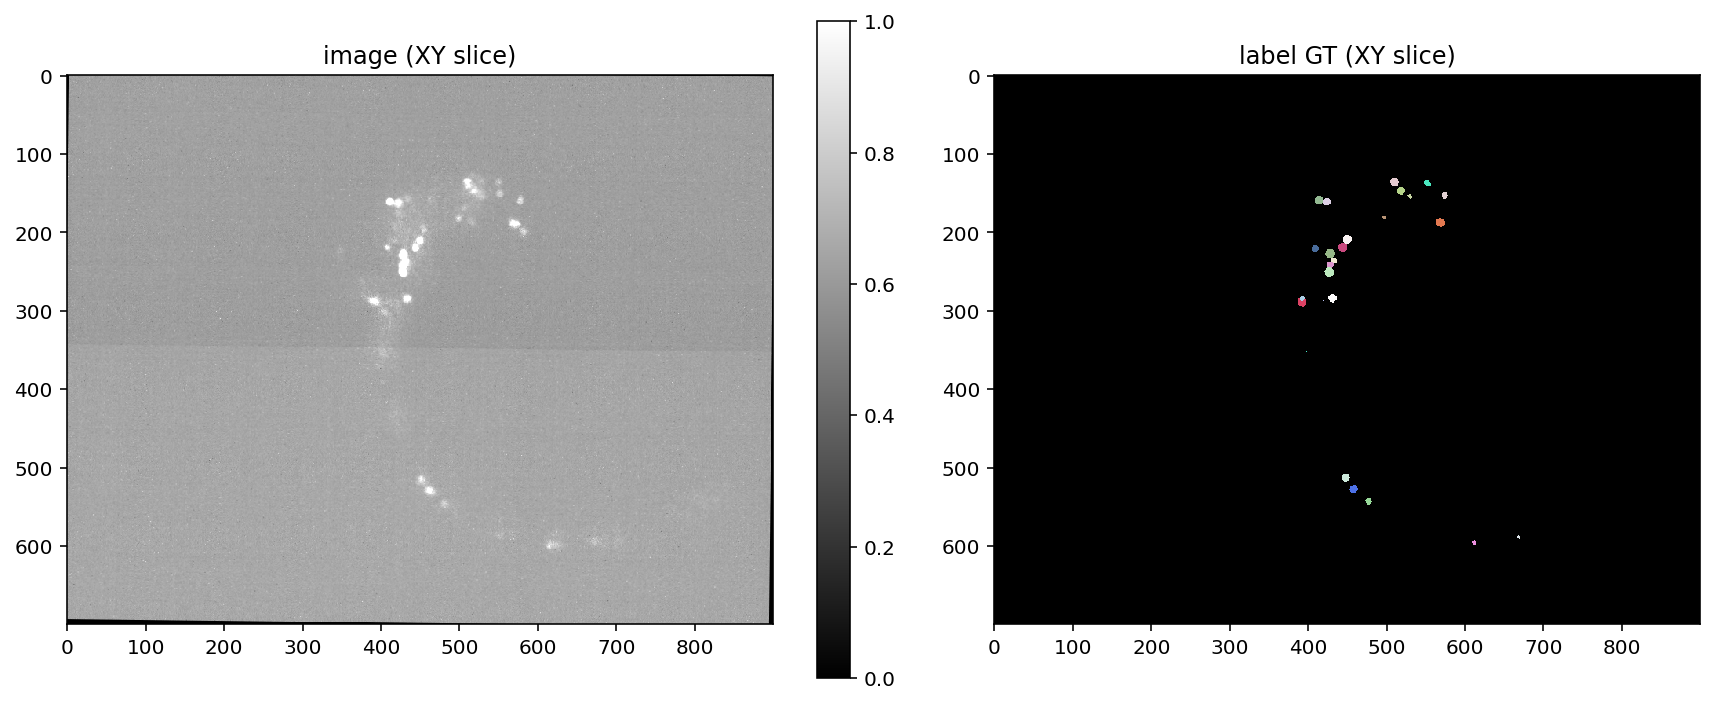

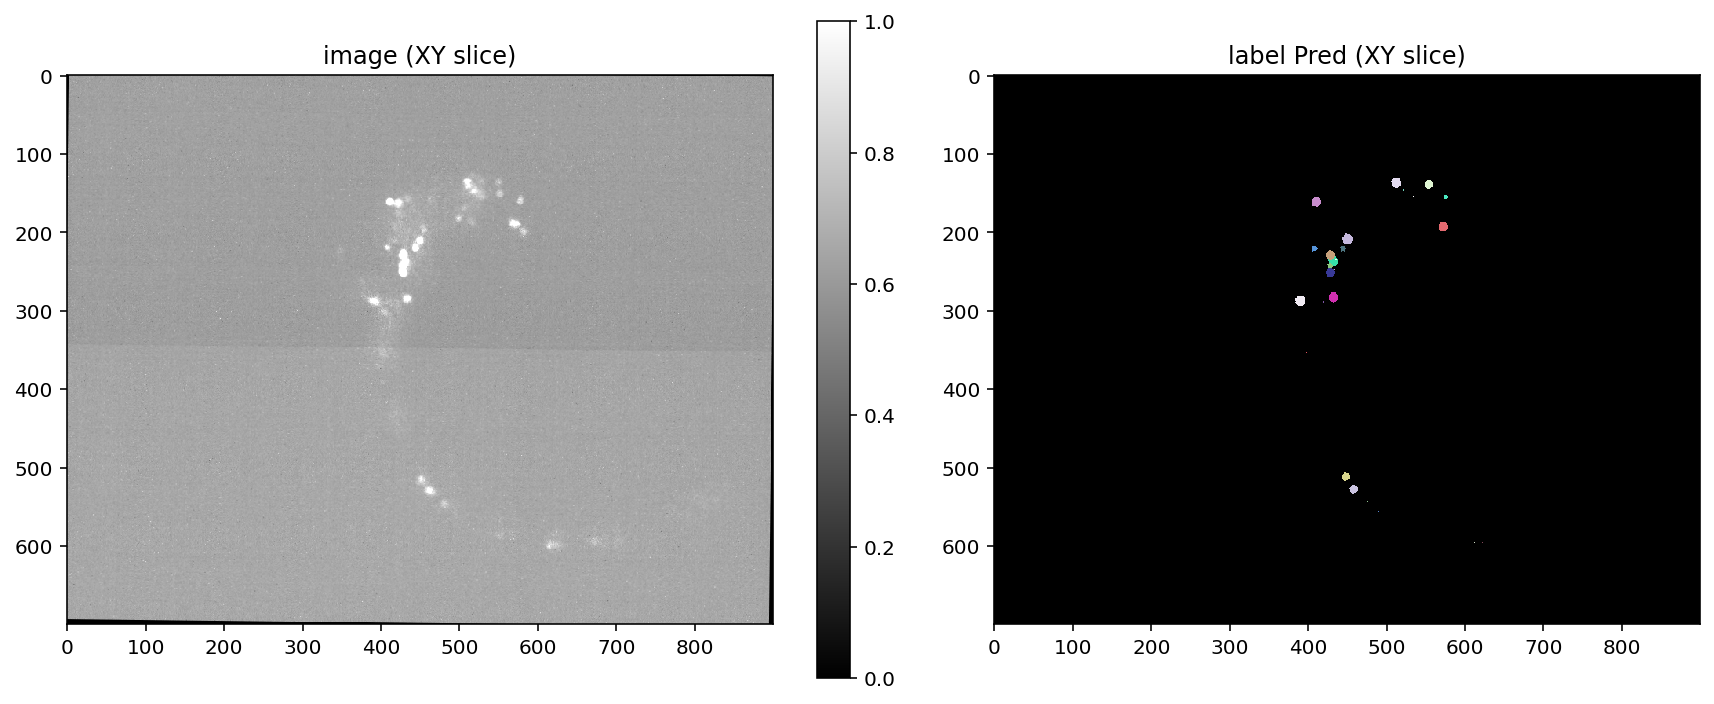

In [44]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [45]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:16<00:00,  1.85s/it]


Example: Print all available matching statistics for $\tau=0.7$

In [46]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=172, tp=3, fn=218, precision=0.017142857142857144, recall=0.013574660633484163, accuracy=0.007633587786259542, f1=0.015151515151515152, n_true=221, n_pred=175, mean_true_score=0.01008284577417158, mean_matched_score=0.7427696386973063, panoptic_quality=0.011254085434807671, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

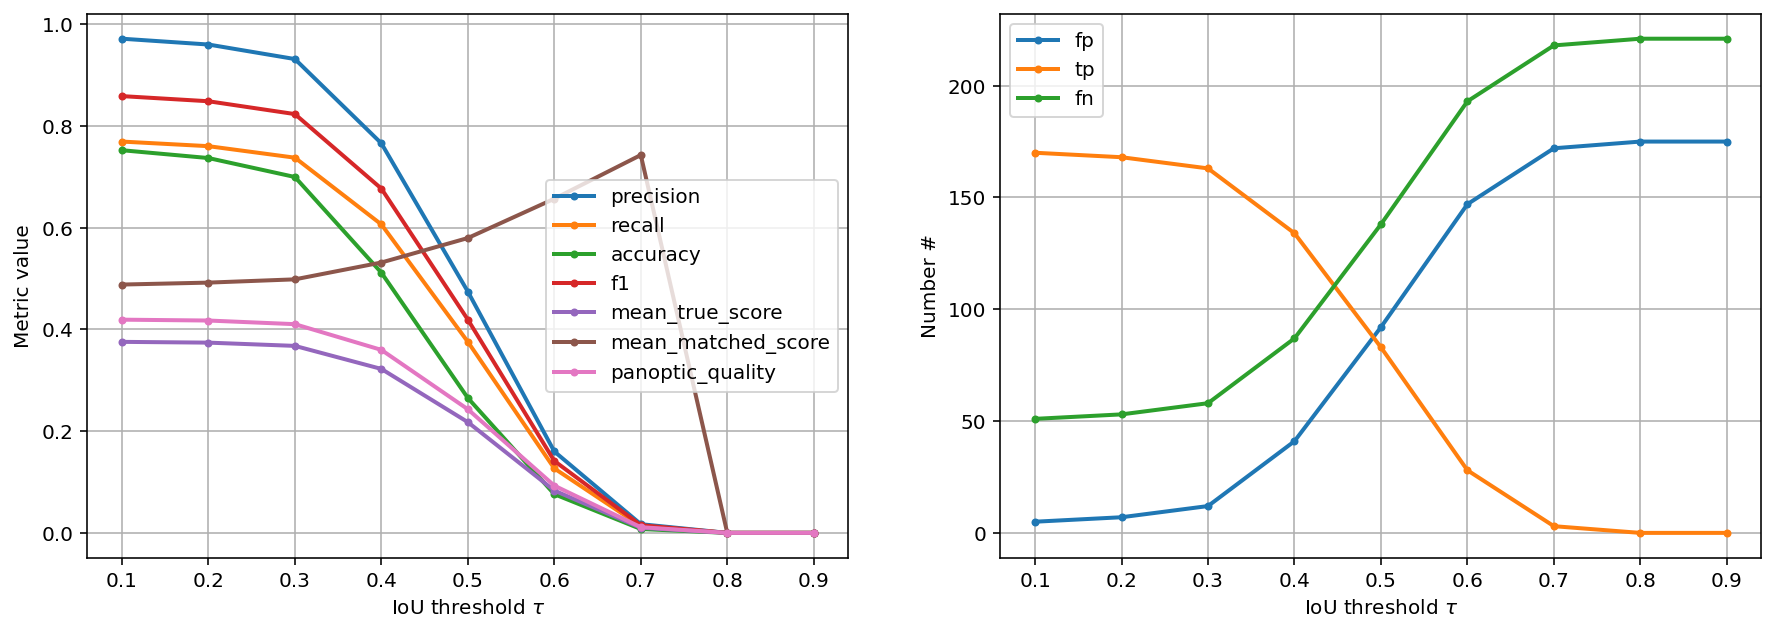

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();